In [505]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile

import sys
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [506]:
from analysis import sweep2df

In [446]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [512]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "k2u5yzbe"


In [513]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"mlp_sweep_{SWEEP_ID}.csv"

In [517]:
runs_df = sweep2df(sweep.runs, filename, True)

In [474]:
runs_df

,name,dim,gamma_square,neg_elbo,kl_loss,rec_loss,prior,cima,mcc,min_cima,...,min_neg_elbo_step,sigma_0,sigma_1,sigma_2,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,rhs_0,rhs_1,rhs_2
0,ethereal-sweep-90,3,1000000.0,-3.242599,-11.740551,14.983148,gaussian,0.000360,0.767906,0.000085,...,7,0.000122,0.000035,0.000081,0.090278,0.168661,0.111621,0.000011,0.000006,0.000009
1,clean-sweep-87,3,1000000.0,-3.413706,-11.826715,15.240421,gaussian,0.000069,0.866228,0.000027,...,11,0.000053,0.000063,0.000036,0.138121,0.128264,0.161940,0.000007,0.000008,0.000006
2,hopeful-sweep-86,3,1000000.0,-3.580147,-11.790291,15.370435,gaussian,0.000175,0.792437,0.000094,...,22,0.000049,0.000045,0.000025,0.138582,0.151055,0.194464,0.000007,0.000007,0.000005
3,revived-sweep-85,3,1000000.0,-4.019059,-11.708535,15.727596,gaussian,0.000209,0.745991,0.000112,...,15,0.000066,0.000062,0.000041,0.120574,0.130505,0.153633,0.000008,0.000008,0.000007
4,atomic-sweep-84,3,1000000.0,-4.121580,-11.765733,15.887312,gaussian,0.000270,0.817822,0.000171,...,29,0.000038,0.000029,0.000021,0.158554,0.187051,0.216121,0.000006,0.000005,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,woven-sweep-5,3,10.0,-0.657169,-0.000897,0.658065,gaussian,0.517752,0.149594,0.250491,...,12,0.950447,0.808007,0.897712,0.003503,0.001498,0.004561,0.966160,0.985242,0.956383
84,pretty-sweep-4,3,10.0,-0.656248,-0.001720,0.657968,gaussian,1.715453,0.148744,0.305176,...,7,0.881029,0.554669,0.831335,0.003702,0.004594,0.005714,0.964305,0.956076,0.945950
85,fancy-sweep-3,3,10.0,-0.657277,-0.000776,0.658053,gaussian,0.648388,0.149397,0.121327,...,17,0.969833,0.969051,0.831029,0.001805,0.001117,0.002588,0.982271,0.988958,0.974770
86,fragrant-sweep-2,3,10.0,-0.657009,-0.000510,0.657519,gaussian,0.891893,0.147239,0.350182,...,13,0.716576,0.848430,0.729243,0.002225,0.002022,0.002948,0.978230,0.980178,0.971369


$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [475]:
runs_df[[ "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

cima4min_neg_elbo                                          \
                         count      mean       std       min       25%   
gamma_square                                                             
10.0                      19.0  1.734660  1.257349  0.305176  0.909448   
1000.0                    19.0  0.005371  0.002101  0.002612  0.004196   
10000.0                   20.0  0.001477  0.000540  0.000922  0.001082   
100000.0                  19.0  0.000452  0.000321  0.000071  0.000231   
1000000.0                 11.0  0.002713  0.006737  0.000036  0.000139   

                                            
                   50%       75%       max  
gamma_square                                
10.0          1.349420  2.353372  4.969462  
1000.0        0.004776  0.006317  0.011041  
10000.0       0.001330  0.001626  0.002736  
100000.0      0.000380  0.000584  0.001352  
1000000.0     0.000334  0.001410  0.022875

In [476]:
runs_df[[ "mcc4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

mcc4min_neg_elbo                                          \
                        count      mean       std       min       25%   
gamma_square                                                            
10.0                     19.0  0.150846  0.002991  0.145966  0.148975   
1000.0                   19.0  0.606738  0.055603  0.531822  0.560346   
10000.0                  20.0  0.776109  0.086634  0.650262  0.699757   
100000.0                 19.0  0.814358  0.063278  0.731892  0.775396   
1000000.0                11.0  0.799284  0.038677  0.741491  0.776567   

                                            
                   50%       75%       max  
gamma_square                                
10.0          0.150477  0.152932  0.156252  
1000.0        0.594857  0.635635  0.702124  
10000.0       0.766400  0.851474  0.932722  
100000.0      0.790145  0.846790  0.938163  
1000000.0     0.796975  0.828204  0.866620

In [504]:
runs_df[[ "min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

min_neg_elbo                                                    \
                    count      mean       std       min       25%       50%   
gamma_square                                                                  
10.0                 19.0 -0.657633  0.000469 -0.658362 -0.657975 -0.657503   
1000.0               19.0 -4.756200  0.006357 -4.766828 -4.759199 -4.757624   
10000.0              20.0 -4.778575  0.046188 -4.848995 -4.809576 -4.784701   
100000.0             19.0 -4.578518  0.070784 -4.675124 -4.617613 -4.594968   
1000000.0            11.0 -4.258692  0.398817 -4.559162 -4.408029 -4.362600   

                                  
                   75%       max  
gamma_square                      
10.0         -0.657256 -0.656916  
1000.0       -4.752296 -4.743974  
10000.0      -4.750788 -4.681943  
100000.0     -4.571037 -4.363631  
1000000.0    -4.299985 -3.089852

In [485]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [486]:
def create_violinplot(groups, xlabel, ylabel, xticklabels, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    vp= plt.violinplot(groups, showmedians=True)
    for el in vp['bodies']:
        el.set_facecolor('#1A85FF')
        el.set_edgecolor('black')
        el.set_linewidth(1.5)
        el.set_alpha(.9)
    for pn in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        vp_ = vp[pn]
        vp_.set_edgecolor('black')
        vp_.set_linewidth(1)
    ax.set_xticklabels(xticklabels)
    # ax.set_xticks(xticks)
    # plt.locator_params(axis='y', nbins=5)
    # plt.yticks(fontsize=24)
    # plt.ylim([0, 0.5])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if filename is not None:
        plt.savefig(f"{filename}.svg")

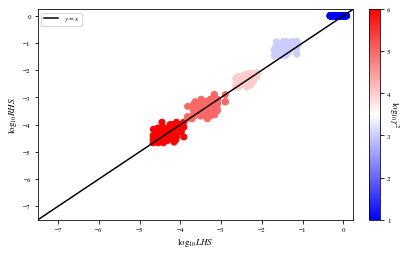

In [487]:
#todo: plot mean/median
plt.scatter(np.log10(df_rhs_lhs_gamma_sq.lhs), np.log10(df_rhs_lhs_gamma_sq.rhs), c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap='bwr')
plt.plot(np.linspace(-7.5, 0.25), np.linspace(-7.5, 0.25), c="black", label='$y=x$')
plt.ylabel('$\log_{10} RHS$')
plt.xlabel('$\log_{10} LHS$')
plt.ylim([-7.5, .25])
plt.xlim([-7.5, .25])
plt.legend()
cbar = plt.colorbar()
# cbar.ax.set_yticklabels(['0','1','2','>3'])
cbar.set_label('$\log_{10}\gamma^2$', rotation=270)
cbar.ax.get_yaxis().labelpad = 10
plt.savefig("rhs_lhs.svg")

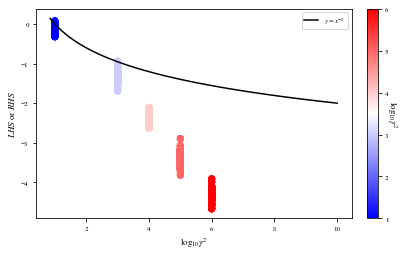

In [497]:
plt.scatter(np.log10(df_rhs_lhs_gamma_sq.gamma_square),np.log10(df_rhs_lhs_gamma_sq.lhs),  c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap="bwr")
plt.scatter(np.log10(df_rhs_lhs_gamma_sq.gamma_square),np.log10(df_rhs_lhs_gamma_sq.rhs), c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap="bwr")
plt.plot(np.linspace(.85, 10), np.log10(1/(np.linspace(.85, 10))**2), c="black", label='$y=x^{-2}$')
plt.legend()
plt.ylabel('$LHS$ or $RHS$')
plt.xlabel('$\log_{10}\gamma^2$')
cbar = plt.colorbar()
# cbar.ax.set_yticklabels(['0','1','2','>3'])
cbar.set_label('$\log_{10}\gamma^2$', rotation=270)
cbar.ax.get_yaxis().labelpad = 10
plt.savefig("rhs_lhs_scaling.svg")

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


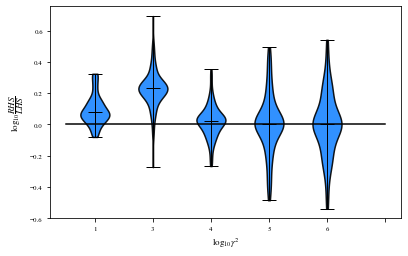

In [503]:
groups = [np.log10((g.rhs/g.lhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
create_violinplot(groups, '$\log_{10}\gamma^2$', '$\log_{10}\dfrac{RHS}{LHS}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="opt_sigma_gamma")
plt.plot(np.linspace(0.5, 6), 0*np.linspace(0.5, 6), c="black")

In [490]:
elbo_filter = runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()['neg_elbo']['max']
groups = [g for _, g in runs_df[[ "neg_elbo", "mcc4min_neg_elbo", "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square")]
gg_mcc = [g[g.neg_elbo <= threshold].mcc4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_cima = [g[g.neg_elbo <= threshold].cima4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_gamma = [g[g.neg_elbo <= threshold].gamma_square  for g, threshold in zip(groups, elbo_filter)]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


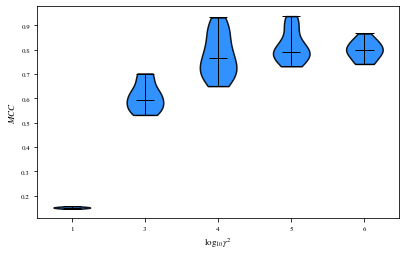

In [491]:
create_violinplot(gg_mcc, '$\log_{10}\gamma^2$', '$MCC$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="mcc_vs_gamma")

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


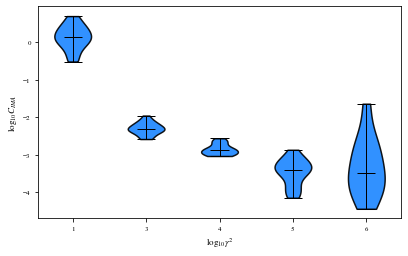

In [492]:
create_violinplot([np.log10(g) for g in gg_cima], '$\log_{10}\gamma^2$', '$\log_{10}C_{IMA}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="cima_vs_gamma")

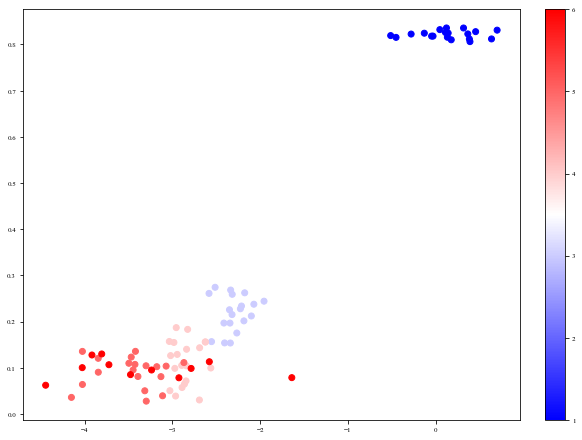

In [493]:
plt.figure(figsize=(8,6))
plt.scatter([np.log10(item) for sublist in gg_cima for item in sublist],[-np.log10(item) for sublist in gg_mcc for item in sublist], c=[np.log10(item) for sublist in gg_gamma for item in sublist], cmap="bwr")
plt.colorbar()

In [494]:
larger_gamma_df = runs_df[runs_df['gamma_square']>100]

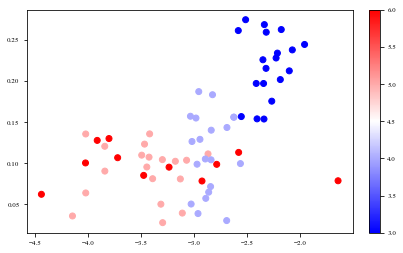

In [495]:
plt.scatter(np.log10(larger_gamma_df['cima4min_neg_elbo']), -np.log10(larger_gamma_df['mcc4min_neg_elbo']), c=np.log10(larger_gamma_df['gamma_square']), cmap='bwr')
plt.colorbar()

In [372]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

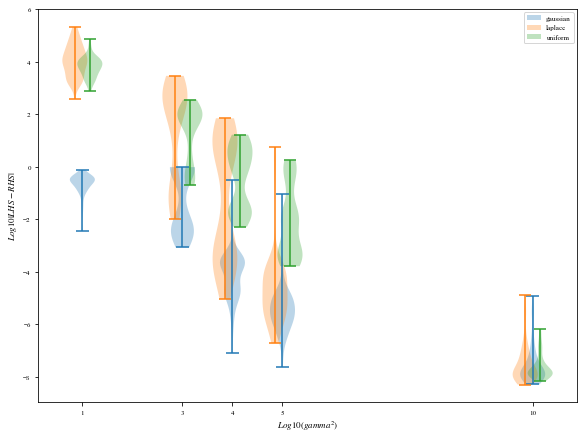

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)